In [1]:
#!g1.1
from torch.profiler import profile, record_function, ProfilerActivity
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from torch.autograd import grad, Variable
from torchvision.utils import save_image
import torch.nn.functional as F
import torch.nn as nn
import torchvision
import torch

from IPython.display import clear_output, HTML, display
from matplotlib import animation, pyplot as plt
from time import gmtime, strftime
from tqdm import tqdm
from PIL import Image
import numpy as np
import wandb
import os

In [16]:
#!g1.1
def Normalize_2D(x, eps=1e-8):
    # Normalization std
    return x * (x.square().mean(-1) + eps).rsqrt().view(-1, 1)


def Normalize_channels(img, eps=1e-8):
    # Normalization mean and std of the channels of the 4D tensor
    assert len(img.shape) == 4
    batch_size, channels = img.size(0), img.size(1)
    mean = img.view(batch_size, channels, -1).mean(dim=2).view(batch_size, channels, 1, 1)
    std = img.view(batch_size, channels, -1).std(dim=2).view(batch_size, channels, 1, 1) + eps
    norm = transforms.Normalize(mean, std)
    return norm(img)


def Generate_map_channels(out_res, start_res=4, max_channels=512, base_channels=8192):
    # Returns the number of channels for each intermediate resolution
    assert base_channels // out_res**2 > 0
    map_channels = dict()
    k = start_res
    while k <= out_res:
        map_channels[k] =  min(base_channels // k**2, max_channels)
        k *= 2
    return map_channels


class Mapping(nn.Module):
    def __init__(self,
                 z_dim: int,           # Dimension of the latent space
                 deep_mapping=8,       # Mapping depth
                 normalize=True,       # Normalization of input vectors
                 eps=1e-8,             # Parameter for normalization stability
                ):
        super().__init__()
        self.dim = z_dim
        self.deep = deep_mapping
        self.normalize = normalize
        self.eps = eps
        self.blocks = []

        # Creating blocks
        for i in range(self.deep - 1):
            self.blocks.append(nn.Sequential(
                nn.Linear(self.dim, self.dim),
                nn.LeakyReLU(0.2),
            ))
        
            # Initializing weights
            nn.init.xavier_normal_(self.blocks[-1][0].weight.data)
            nn.init.zeros_(self.blocks[-1][0].bias.data)

        self.blocks.append(nn.Linear(self.dim, self.dim))
        nn.init.xavier_normal_(self.blocks[-1].weight.data)
        nn.init.zeros_(self.blocks[-1].bias.data)
        
        # Registering parameters in the model
        self.blocks = nn.ModuleList(self.blocks)


    def forward(self, z):
        if self.normalize:
            z = Normalize_2D(z, self.eps)
        for block in self.blocks:
            z = block(z)
        return z


class AdaIN(nn.Module):
    def __init__(self,
                 latent_size: int,     # Dimension of the latent space
                 channels: int,        # The number of channels in the image
                ):
        super().__init__()
        self.size = latent_size
        self.channels = channels

        # Affine transformation
        self.A = nn.Linear(self.size, 2 * channels)
        
        # Weights for noise
        self.B = nn.Parameter(torch.zeros(channels))

        # Initializing weights
        nn.init.xavier_normal_(self.A.weight.data)
        nn.init.zeros_(self.A.bias.data)
        

    def forward(self, x, w):
        # Apply noise
        noise = torch.randn(x.shape, device=x.device)
        x = x + self.B.view(1, -1, 1, 1) * noise

        # Apply style
        x = Normalize_channels(x)
        style = self.A(w).view(2, -1, self.channels, 1, 1)
        x = (1 + style[0]) * x + style[1]
        return x


class BlockG(nn.Module):
    def __init__(self,
                 res_in: int,          # Input image resolution
                 res_out: int,         # Output image resolution
                 in_channels: int,     # Input number of channels
                 out_channels: int,    # Output number of channels
                 latent_size: int,     # Dimension of the latent space
                 first_block=False,    # Disables upsampling for the first block
                 last_block=False,     # Disables activation for the last block
                 bilinear_up=False,    # Uses bilinear upsampling, otherwise progressive
                 ):
        super().__init__()
        self.res_in = res_in
        self.res_out = res_out
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.latent_size = latent_size
        self.first_block = first_block
        self.last_block = last_block

        # Selecting the upsampling type
        if bilinear_up:
            self.up_sample = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        else:
            self.up_sample = nn.Sequential(
                nn.ConvTranspose2d(in_channels, in_channels, 2, 2),
                nn.LeakyReLU(0.2),
            )
            nn.init.kaiming_normal_(self.up_sample[0].weight.data)
            nn.init.zeros_(self.up_sample[0].bias.data)
            
        
        # Creating layers
        self.AdaIN1 = AdaIN(self.latent_size, in_channels)
        self.Conv = nn.Conv2d(in_channels, out_channels, 3, 1, 1)
        self.Act = nn.LeakyReLU(0.2)
        self.AdaIN2 = AdaIN(self.latent_size, out_channels)

        # Initializing weights
        nn.init.kaiming_normal_(self.Conv.weight.data)
        nn.init.zeros_(self.Conv.bias.data)


    def forward(self, x, w):
        assert len(x.shape) == 4

        # upsampling
        if not self.first_block:
            x = self.up_sample(x)

        x = self.AdaIN1(x, w)
        x = self.Conv(x)
        if not self.last_block:
            x = self.Act(x)
        x = self.AdaIN2(x, w)
        return x


class Generator(nn.Module):
    def __init__(self,
                 res: int,             # Generated image resolution
                 RGB=True,             # Color or gray image
                 deep_mapping=8,       #  Mapping depth
                 start_res=4,          # Initial resolution of the constant
                 channel_base=8192,    # Value, for calculating the number of intermediate channels
                 max_channels=512,     # Maximum number of channels in intermediate images
                 latent_size=512,      # Dimension of the latent space
                 bilinear=True,        # Using bilinear or progressive upsampling
                 normalize=True,       # Normalization of the input vector z
                 eps=1e-8,             # Parameter for normalization stability
                 ):
        super().__init__()
        assert 2**round(np.log2(res)) == res
        self.res = res
        self.out_channels = 3 if RGB else 1
        self.deep_mapping = deep_mapping
        self.latent_size = latent_size
        self.eps = eps

        # Calculating the number of channels for each resolution
        self.map_channels = Generate_map_channels(res, start_res, max_channels, channel_base)

        # Initializing layers
        self.mapping = Mapping(latent_size, deep_mapping, normalize, eps)
        self.const = nn.Parameter(torch.ones(max_channels, start_res, start_res))
        self.blocks = [BlockG(start_res, start_res, max_channels, self.map_channels[start_res], latent_size, first_block=True, bilinear_up=bilinear)]
        self.to_rgb = nn.Conv2d(self.map_channels[res], self.out_channels, 1, 1)
        
        # Initializing weights
        nn.init.kaiming_normal_(self.to_rgb.weight.data)
        nn.init.zeros_(self.to_rgb.bias.data)

        # Creating blocks
        to_res = 8
        while to_res <= res:
            in_channels = self.map_channels[to_res//2]
            out_channels = self.map_channels[to_res]
            self.blocks.append(
                BlockG(to_res//2, to_res, in_channels, out_channels, latent_size, last_block=(to_res == res), bilinear_up=bilinear)
            )
            to_res *= 2
        
        # Registering parameters in the model
        self.blocks = nn.ModuleList(self.blocks)

        
    def forward(self, z):
        w = self.mapping(z)
        img = self.const.expand(w.size(0), -1, -1, -1)
        for block in self.blocks:
            img = block(img, w)
        return self.to_rgb(img)


class BlockD(nn.Module):
    def __init__(self,
                 res_in: int,          # Input image resolution
                 res_out: int,         # Output image resolution
                 in_channels: int,     # Input number of channels
                 out_channels: int,    # Output number of channels
                 last_block=False,     # Disables non-linearity on the last block
                 bilinear_down=True,   # Bilinear or progressive downsampling
                 ):
        super().__init__()
        self.res_in = res_in
        self.res_out = res_out
        self.in_channels = in_channels
        self.out_channels = out_channels

        if bilinear_down:
            self.down_sample = nn.AvgPool2d(3, 2, padding=1)
        else:
            self.down_sample = nn.Conv2d(out_channels, out_channels, 2, 2)
            nn.init.kaiming_normal_(self.down_sample.weight.data)
            nn.init.zeros_(self.down_sample.bias.data)

        self.Conv = nn.Conv2d(in_channels, out_channels, 3, 1, 1)
        self.act1 = nn.LeakyReLU(0.2)
        self.act2 = nn.LeakyReLU(0.2)
        
        # initializing weights
        nn.init.kaiming_normal_(self.Conv.weight.data)
        nn.init.zeros_(self.Conv.bias.data)


    def forward(self, x):
        x = self.Conv(x)
        x = self.act1(x)
        x = self.down_sample(x)
        x = self.act2(x)
        return x


class Discriminator(nn.Module):
    def __init__(self,
                 res,                  # Input resolution of images
                 RGB=True,             # Color or gray images
                 bilinear=False,       # Bilinear or progressive downsampling
                 last_res=4,           # The last resolution of the image before the linear layers
                 channel_base=8192,    # Value, for calculating the number of intermediate channels
                 max_channels=512,     # Maximum number of channels in intermediate images
                ):
        super().__init__()
        assert 2**round(np.log2(res)) == res
        self.res = res
        self.in_channels = 3 if RGB else 1
        self.blocks = []

        # Calculating the number of channels for each resolution
        self.map_channels = Generate_map_channels(res, last_res, max_channels, channel_base)

        # Creating blocks
        to = res//2
        while to >= 4:
            if to == 4:
                self.blocks.append(BlockD(2*to, to, self.map_channels[2*to], self.map_channels[to], True, bilinear))
            else:
                self.blocks.append(BlockD(2*to, to, self.map_channels[2*to], self.map_channels[to], bilinear_down=bilinear))
            to //= 2

        self.fromRGB = nn.Conv2d(self.in_channels, self.map_channels[res], 3, 1, 1)
        self.func = nn.Sequential(
            nn.Linear(self.map_channels[4] * 4**2, 512),
            nn.LeakyReLU(0.2),
            nn.Linear(512, 1),
        )

        # initializing weights
        nn.init.xavier_normal_(self.func[0].weight.data)
        nn.init.xavier_normal_(self.func[2].weight.data)
        nn.init.zeros_(self.func[0].bias.data)
        nn.init.zeros_(self.func[2].bias.data)
        
        # Registering parameters in the model
        self.blocks = nn.ModuleList(self.blocks)


    def forward(self, img):
        img = img.view(-1, self.in_channels, self.res, self.res)
        img = self.fromRGB(img)
        for block in self.blocks:
            img = block(img)
        return self.func(img.view(img.size(0), -1))


In [3]:
#!g1.1
wandb.login()

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: maximkm (use `wandb login --relogin` to force relogin)


True

In [4]:
#!g1.1
# Setting up the main training parameters
wandb.init(
    project='StyleGAN-E',
    config={
        'IMG_SIZE': 32,
        'UPD_FOR_GEN': 1,
        'BATCH_SIZE': 2048,
        'LATENT': 256,
        'lambda_gp': 10,
        'deep_mapping': 6,
        'channel_base': 8192,
        'bilinear': True,
        'lr_G': 0.002,
        'lr_D': 0.002,
        'beta1_G': 0.5,
        'beta2_G': 0.9,
        'beta1_D': 0.5,
        'beta2_D': 0.9,
        'Dataset': 'DataGAN',
        'epochs': 5000,
    }
)
conf = wandb.config
Weight_dir = 'WeightGAN'
output = 'ResultGAN'
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

wandb: wandb version 0.11.0 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


In [5]:
#!g1.1
class ImageDataset(Dataset):
    def __init__(self, data_root, transform):
        self.samples = []
        self.transform = transform

        for class_dir in os.listdir(data_root):
            data_folder = os.path.join(data_root, class_dir)

            for image_dir in tqdm(os.listdir(data_folder)):
                img = Image.open(f'{data_folder}/{image_dir}')
                img = img.convert("RGB")
                self.samples.append(self.transform(img))


    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        return self.samples[idx]

In [6]:
#!g1.1
# Load train image
transform = transforms.Compose(
    [
     transforms.Resize((conf.IMG_SIZE, conf.IMG_SIZE)),
     transforms.ToTensor(),
     transforms.Normalize((0.5), (0.5)),
     ]
    )

dataset = ImageDataset(conf.Dataset, transform=transform)

100%|██████████| 21551/21551 [00:57<00:00, 377.75it/s]


In [7]:
#!g1.1
dataloader = DataLoader(dataset, batch_size=conf.BATCH_SIZE, shuffle=True, num_workers=4, pin_memory=True)

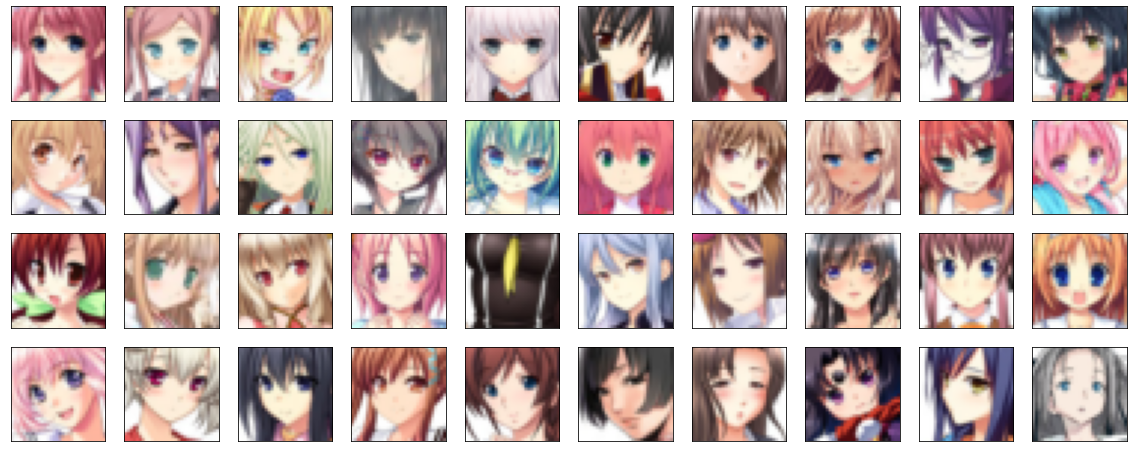

In [8]:
#!g1.1
def TensorToImage(img, mean=0.5, std=0.5):
    # Convert a tensor to an image
    img = np.transpose(img.numpy(), (1, 2, 0))
    img = (img*std + mean)*255
    img = img.astype(np.uint8)    
    return img  


# Plot some train image
random_img = lambda: int(np.random.rand(1)[0] * len(dataset))
plot_width, plot_height = 10, 4

fig = plt.figure(figsize=(2 * plot_width, 2 * plot_height))
for sample_n in range(1, plot_width * plot_height + 1):
    ax = fig.add_subplot(plot_height, plot_width, sample_n)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    plt.imshow(TensorToImage(dataset[random_img()]))

In [17]:
#!g1.1
# Create the model
start_epoch = 0
G = Generator(conf.IMG_SIZE, deep_mapping=conf.deep_mapping, latent_size=conf.LATENT, bilinear=conf.bilinear, channel_base=conf.channel_base)
D = Discriminator(conf.IMG_SIZE, bilinear=conf.bilinear, channel_base=conf.channel_base)
wandb.watch(G)
wandb.watch(D)

# Load the pre-trained weight
name_to_epoch = lambda x: int(x.replace('.pth', '').replace('weight ', ''))
last_epoch = sorted([name_to_epoch(elem) for elem in os.listdir(Weight_dir)])[-1]
if os.path.exists(f'{Weight_dir}/weight {last_epoch}.pth'):
    print(f'Load the pre-trained weight {last_epoch}')
    state = torch.load(f'{Weight_dir}/weight {last_epoch}.pth')
    G.load_state_dict(state['G'])
    D.load_state_dict(state['D'])
    start_epoch = state['start_epoch']


# Multi-GPU support
if torch.cuda.device_count() > 1:
    print(f'Avalible {torch.cuda.device_count()} GPUs')
    G = nn.DataParallel(G)
    D = nn.DataParallel(D)
G.to(device)
D.to(device)

# Create the criterion, optimizer and scheduler
optim_D = torch.optim.Adam(D.parameters(), lr=conf.lr_D, betas=(conf.beta1_D, conf.beta2_D))
optim_G = torch.optim.Adam(G.parameters(), lr=conf.lr_G, betas=(conf.beta1_G, conf.beta2_G))
scheduler_D = torch.optim.lr_scheduler.ExponentialLR(optim_D, gamma=0.99)
scheduler_G = torch.optim.lr_scheduler.ExponentialLR(optim_G, gamma=0.99)

Load the pre-trained weight 1000


/kernel/lib/python3.7/site-packages/ml_kernel/kernel.py:815: UserWarning: The following variables cannot be serialized: conf
  warnings.warn(message)


In [10]:
#!g1.1
for name, param in G.named_parameters():
    if param.requires_grad:
        print(name)

const
mapping.blocks.0.0.weight
mapping.blocks.0.0.bias
mapping.blocks.1.0.weight
mapping.blocks.1.0.bias
mapping.blocks.2.0.weight
mapping.blocks.2.0.bias
mapping.blocks.3.0.weight
mapping.blocks.3.0.bias
mapping.blocks.4.0.weight
mapping.blocks.4.0.bias
mapping.blocks.5.weight
mapping.blocks.5.bias
to_rgb.weight
to_rgb.bias
blocks.0.AdaIN1.B
blocks.0.AdaIN1.A.weight
blocks.0.AdaIN1.A.bias
blocks.0.Conv.weight
blocks.0.Conv.bias
blocks.0.AdaIN2.B
blocks.0.AdaIN2.A.weight
blocks.0.AdaIN2.A.bias
blocks.1.AdaIN1.B
blocks.1.AdaIN1.A.weight
blocks.1.AdaIN1.A.bias
blocks.1.Conv.weight
blocks.1.Conv.bias
blocks.1.AdaIN2.B
blocks.1.AdaIN2.A.weight
blocks.1.AdaIN2.A.bias
blocks.2.AdaIN1.B
blocks.2.AdaIN1.A.weight
blocks.2.AdaIN1.A.bias
blocks.2.Conv.weight
blocks.2.Conv.bias
blocks.2.AdaIN2.B
blocks.2.AdaIN2.A.weight
blocks.2.AdaIN2.A.bias
blocks.3.AdaIN1.B
blocks.3.AdaIN1.A.weight
blocks.3.AdaIN1.A.bias
blocks.3.Conv.weight
blocks.3.Conv.bias
blocks.3.AdaIN2.B
blocks.3.AdaIN2.A.weight
blocks.

In [11]:
#!g1.1
sum(p.numel() for p in G.parameters() if p.requires_grad)

4351899

In [12]:
#!g1.1
Tensor = torch.cuda.FloatTensor if torch.cuda.is_available() else torch.FloatTensor

def compute_gradient_penalty(D, real_samples, fake_samples):
    # Calculates the gradient penalty loss for WGAN GP
    # Random weight term for interpolation between real and fake samples
    alpha = torch.randn((real_samples.size(0), 1, 1, 1), device=device)
    # Get random interpolation between real and fake samples
    interpolates = (alpha * real_samples + ((1 - alpha) * fake_samples)).requires_grad_(True)
    d_interpolates = D(interpolates)
    fake = Tensor(real_samples.shape[0], 1).fill_(1.0).requires_grad_(False)
    # Get gradient w.r.t. interpolates
    gradients = grad(
        outputs=d_interpolates,
        inputs=interpolates,
        grad_outputs=fake,
        create_graph=True,
        retain_graph=True,
        only_inputs=True,
    )[0]
    gradients = gradients.view(gradients.size(0), -1)
    gradient_penalty = ((gradients.norm(2, dim=1) - 1) ** 2).mean()
    return gradient_penalty

In [13]:
#!g1.1
!nvidia-smi

Sat Jul 17 01:08:50 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:8C:00.0 Off |                    0 |
| N/A   32C    P0    36W / 300W |   1427MiB / 32510MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [14]:
#!g1.1
# Train
def train_loop():
    fix_z = torch.randn([conf.BATCH_SIZE, conf.LATENT], device=device)
    for epoch in range(start_epoch, conf.epochs):
        bar = tqdm(dataloader)
        loss_G = []
        loss_D = []
        for i, real_img in enumerate(bar):
            # (1) Update D network
            real_imgs = real_img.to(device)
            optim_D.zero_grad()

            # Sample noise as generator input
            z = torch.randn((real_imgs.size(0), conf.LATENT), device=device)

            # Generate a batch of images
            fake_imgs = G(z)

            # Real images
            real_validity = D(real_imgs)
            # Fake images
            fake_validity = D(fake_imgs.detach())
            # Gradient penalty
            gradient_penalty = compute_gradient_penalty(D, real_imgs.data, fake_imgs.data)
            # Adversarial loss
            d_loss = -torch.mean(real_validity) + torch.mean(fake_validity) + conf.lambda_gp * gradient_penalty

            d_loss.backward()
            optim_D.step()
            
            loss_D.append(d_loss.item())
            wandb.log({"loss_D":d_loss.item()})

            optim_G.zero_grad()
            # (2) Update G network
            if i % conf.UPD_FOR_GEN == 0:
                # Loss measures generator's ability to fool the discriminator
                # Train on fake images
                fake_validity = D(fake_imgs)
                g_loss = -torch.mean(fake_validity)

                g_loss.backward()
                optim_G.step()

                loss_G.append(g_loss.item())
                wandb.log({"loss_G":g_loss.item()})

            # Generate test image
            if (i+1) % (len(dataloader) // 2) == 0:
                with torch.no_grad():
                    fake_img = G(fix_z).detach().cpu()
                    save_image(fake_img, f'{output}/{strftime("%Y-%m-%d %H-%M", gmtime())} {epoch}.png', normalize=True)

            # Output training stats
            if (i+1) % 2*(i+1) == 0:
                clear_output(wait=True)
                with torch.no_grad():
                    Image = TensorToImage(G(torch.randn(conf.LATENT, device=device)).detach().cpu()[0], 0.5, 0.225)
                    wandb.log({"Random generated face": wandb.Image(Image)})

            clear_output(wait=True)        
            bar.set_description(f"Epoch {epoch + 1}/{conf.epochs} [{i+1}, {len(dataloader)}]")

        # Save model
        state = {
            'G': G.state_dict(),
            'D': D.state_dict(),
            'start_epoch': epoch + 1,
        }
        torch.save(state, f'{Weight_dir}/weight {epoch + 1}.pth')
        wandb.log({"mean_loss_G":np.mean(loss_G), "mean_loss_D":np.mean(loss_D)})
        
        scheduler_D.step()
        scheduler_G.step()

In [ ]:
#!g1.1
train_loop()

Epoch 1004/5000 [7, 11]:  64%|██████▎   | 7/11 [00:09<00:05,  1.32s/it]

In [ ]:
#!g1.1
wandb.finish()

In [ ]:
#!g1.1
# Plot generated image
random_img = lambda: int(np.random.rand(1)[0] * len(dataset))
plot_width, plot_height = 10, 10

fig = plt.figure(figsize=(3 * plot_width, 3 * plot_height))
for sample_n in range(1, plot_width * plot_height + 1):
    ax = fig.add_subplot(plot_height, plot_width, sample_n)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    z = torch.randn(conf.LATENT).to(device)
    plt.imshow(TensorToImage(G(z).view(3, conf.IMG_SIZE, conf.IMG_SIZE).detach().cpu(), 0.5, 0.225))

In [ ]:
#!g1.1
from matplotlib import animation
from matplotlib.animation import FuncAnimation
from IPython.display import HTML, display


def process_image(img):
    if len(img.shape) == 4:
        img = img[0]
    plt.axis('off')
    return [plt.imshow(TensorToImage(img, 0.5, 0.225))]

def generate_video(samples_list, delay=1000):
    fig = plt.figure(figsize=(8, 8))
    plt.axis('off')
    frames = [process_image(elem) for elem in samples_list]
    
    ani = animation.ArtistAnimation(fig, frames, interval=delay)  
    display(HTML(ani.to_html5_video()))

In [ ]:
#!g1.1
generate_video(G(torch.randn(256, 256).to(device)).detach().cpu())

In [ ]:
#!g1.1
def noise_video(z, frames=100):
    samples = []
    z = z.to(device)
    for i in range(frames):
        samples.append(G(z).detach().cpu()[0])
    return samples
        
generate_video(noise_video(torch.randn(256)), 1000//30)

In [ ]:
#!g1.1
def from_to_video(z_1, z_2, frames=200):
    samples = []
    z_1 = z_1.to(device)
    z_2 = z_2.to(device)
    delta = ((z_2 - z_1)/(frames - 1)).to(device)
    for i in range(frames):
        samples.append(G(z_1 + i*delta).detach().cpu()[0])
    return samples
    
generate_video(from_to_video(torch.randn(256), torch.randn(256)), 1000//30)

In [ ]:
#!g1.1
z = torch.randn(256)
generate_video(from_to_video(z, -z), 1000//30)

In [ ]:
#!g1.1
